In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import yaml
import pickle as pickle
import pandas as pd
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
import colorcet as cc
from shapely.geometry.polygon import Polygon
import shapely.ops as ops
from functools import partial
import pyproj

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# Setup

In [2]:
# Read config file
config = yaml.load(open("/home/ubuntu/setup_CH4/config.yml"), Loader=yaml.FullLoader)

In [3]:
# Open the state vector file
state_vector_filepath = './../StateVector.nc'
state_vector = xr.open_dataset(state_vector_filepath)
state_vector_labels = state_vector['StateVector']

# Identify the last element of the region of interest
last_ROI_element = int(np.nanmax(state_vector_labels.values) - config['nBufferClusters'])

In [4]:
# Set radius for spatial plots
window_radius = 5 # degrees; modify as needed

# Functions

In [5]:
def plot_field(ax, field, cmap, plot_type='pcolormesh', lon_bounds=None, lat_bounds=None, 
               levels=21, vmin=None, vmax=None, title=None, cbar_label=None, mask=None, only_ROI=False):
    '''
    Function to plot inversion results.
    
    Arguments
        ax         : matplotlib axis object
        field      : xarray dataarray
        cmap       : colormap to use, e.g. 'viridis'
        plot_type  : 'pcolormesh' or 'imshow'
        lon_bounds : [lon_min, lon_max]
        lat_bounds : [lat_min, lat_max]
        levels     : number of levels for pcolormesh option
        vmin       : colorbar lower bound
        vmax       : colorbar upper bound
        title      : plot title
        cbar_label : colorbar label
        mask       : mask for region of interest, boolean dataarray
        only_ROI   : zero out data outside the region of interest, true or false
    '''
    
    # Select map features
    oceans_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')
    lakes_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '50m')
    states_provinces_50m = cartopy.feature.NaturalEarthFeature('cultural','admin_1_states_provinces_lines', '50m')
    ax.add_feature(cartopy.feature.BORDERS, facecolor='none')
    ax.add_feature(oceans_50m, facecolor=[1,1,1], edgecolor='black')
    ax.add_feature(lakes_50m, facecolor=[1,1,1], edgecolor='black')
    ax.add_feature(states_provinces_50m, facecolor='none', edgecolor='black')
    
    # Show only ROI values?
    if only_ROI:
        field = field.where((state_vector_labels <= last_ROI_element))  
    
    # Plot
    if plot_type == 'pcolormesh':
        field.plot.pcolormesh(cmap=cmap, levels=levels, ax=ax,
                              vmin=vmin, vmax=vmax, cbar_kwargs={'label':cbar_label,
                                                                 'fraction':0.041, 
                                                                 'pad':0.04})
    elif plot_type == 'imshow':
        field.plot.imshow(cmap=cmap, ax=ax,
                          vmin=vmin, vmax=vmax, cbar_kwargs={'label':cbar_label,
                                                             'fraction':0.041, 
                                                             'pad':0.04})
    else:
        raise ValueError('plot_type must be "pcolormesh" or "imshow"')
    
    # Zoom on ROI?
    if lon_bounds and lat_bounds:
        extent = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Show boundary of ROI?
    if mask is not None:
        mask.plot.contour(levels=1,colors='k',linewidths=2,ax=ax);
    
    # Remove duplicated axis labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0)
    gl.right_labels = False
    gl.top_labels = False
    
    # Title
    if title:
        ax.set_title(title);

        
def load_obj(name):
    """ Load something with Pickle. """
    with open( name, 'rb') as f:
        return pickle.load(f)
    

def calculate_gridcell_areas(state_vector, mask, dlat, dlon):
    '''
    Compute the surface areas of grid cells in the region of interest, in m2.
    '''
    xgrid = range(len(state_vector.lon.values))
    ygrid = range(len(state_vector.lat.values))
    areas = []
    for j in xgrid:
        for i in ygrid:
            if mask.values[i,j] == 1:
                lat_top = state_vector.lat.values[i] + dlat
                lat_bot = state_vector.lat.values[i] - dlat
                lon_left = state_vector.lon.values[j] - dlon
                lon_righ = state_vector.lon.values[j] + dlon
                geom = Polygon([(lon_left, lat_bot), (lon_left, lat_top), (lon_righ, lat_top), 
                                (lon_righ, lat_bot), (lon_left, lat_bot)])
                geom_area = ops.transform(
                                        partial(
                                            pyproj.transform,
                                            pyproj.Proj(init='EPSG:4326'),
                                            pyproj.Proj(
                                                proj='aea',
                                                lat_1=geom.bounds[1],
                                                lat_2=geom.bounds[3])),
                                        geom)
                areas.append(geom_area.area)
    return areas
    
    
def sum_total_emissions(emissions, areas, state_vector_labels, last_ROI_element):
    '''
    Function to sum total emissions across the region of interest.
    
    Arguments:
        emissions           : emissions dataarray
        areas               : list of pixel areas (in m2) for region of interest
        state_vector_labels : state vector element IDs, dataarray
        last_ROI_element    : ID of last state vector element in the region of interest
        
    Returns:
        Total emissions in Tg/y
    '''
    s_per_d = 86400
    d_per_y = 365
    tg_per_kg = 1e-9
    xgrid = range(len(state_vector_labels.lon.values))
    ygrid = range(len(state_vector_labels.lat.values))    
    mask = (state_vector_labels <= last_ROI_element)
    emiss = []
    for j in xgrid:
        for i in ygrid:
            if mask.values[i,j] == 1:
                emiss.append(emissions.values[i,j])
    total = np.sum(np.asarray([areas[r] * emiss[r] for r in range(len(areas))]))
    return total * s_per_d * d_per_y * tg_per_kg

# Show state vector

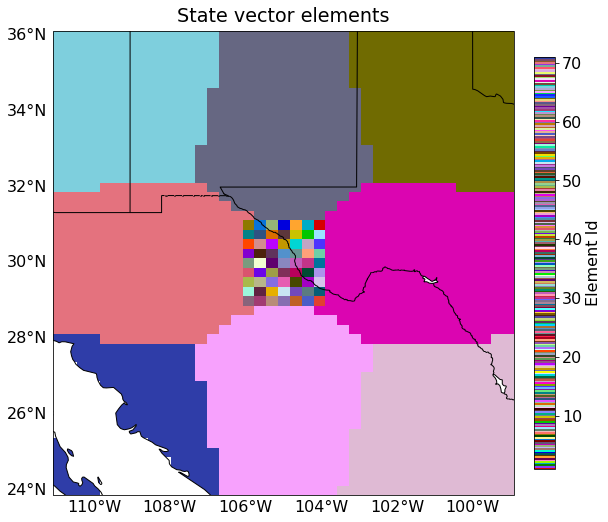

In [6]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, state_vector_labels, plot_type='imshow', cmap=cc.cm.glasbey, 
           title='State vector elements', cbar_label='Element Id')

# Inversion results

In [7]:
# Paths to prior emissions, inversion results, GEOS/satellite data, posterior simulation
prior_pth = f'./../jacobian_runs/{config["RunName"]}_0000/OutputDir/HEMCO_diagnostics.{config["StartDate"]}0000.nc'
results_pth = './gridded_posterior.nc'
satdat_dir = './data_converted'
inversion_result_path = './inversion_result.nc'
#posterior_dir = './../demonstration_data/edf_posterior/sampling_output'

In [8]:
# Set latitude/longitude bounds for plots
mean_lon = np.mean(state_vector.lon.values)
mean_lat = np.mean(state_vector.lat.values)
lon_bounds = [mean_lon-window_radius, mean_lon+window_radius]
lat_bounds = [mean_lat-window_radius, mean_lat+window_radius]

In [9]:
# Define mask for ROI, to be used below
mask = (state_vector_labels <= last_ROI_element)

### Prior and Posterior emissions

In [10]:
# Load prior emissions and optimized scale factors
# Then compute posterior emissions
prior = xr.open_dataset(prior_pth)['EmisCH4_Total'].isel(time=0)
scale = xr.open_dataset(results_pth)['ScaleFactor']
posterior = prior * scale

In [11]:
# Compute total emissions
if config['Res'] == '0.25x0.3125':
    dlat=0.25/2
    dlon=0.3125/2
elif config['Res'] == '0.5x0.625':
    dlat=0.5/2
    dlon=0.625/2
    
areas = calculate_gridcell_areas(state_vector, mask, dlat, dlon)

In [12]:
print('Prior     emissions :', sum_total_emissions(prior, areas, state_vector_labels, last_ROI_element), 'Tg/y')
print('Posterior emissions :', sum_total_emissions(posterior, areas, state_vector_labels, last_ROI_element), 'Tg/y')

Prior     emissions : -0.013901477696223697 Tg/y
Posterior emissions : -0.013861901712774084 Tg/y


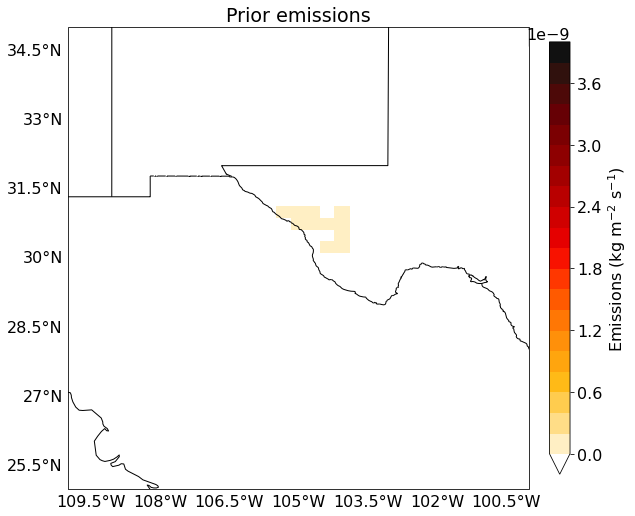

In [13]:
# Plot prior emissions
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, prior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Prior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True)

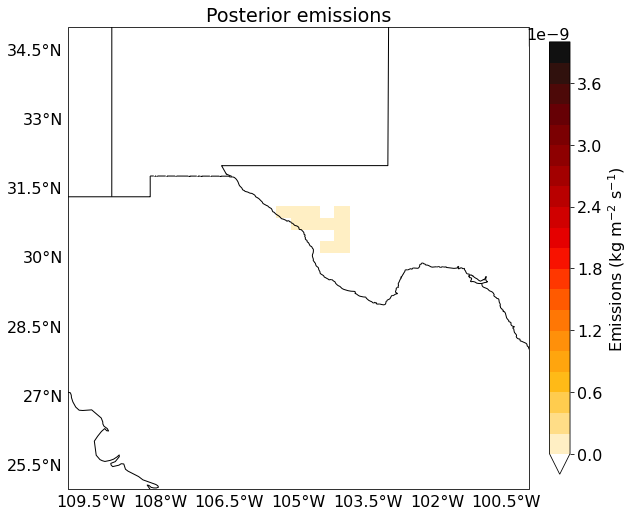

In [14]:
# Plot posterior emissions
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, posterior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Posterior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True)

### Scale factors

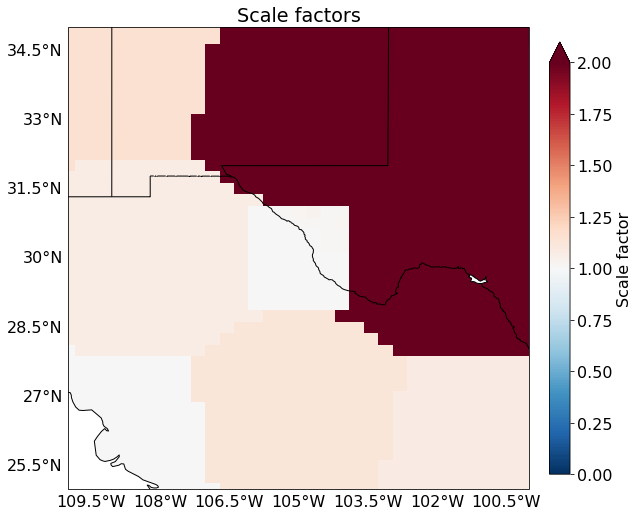

In [15]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, scale, cmap='RdBu_r', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=2, title='Scale factors', cbar_label='Scale factor',
           only_ROI=False)

### Averaging kernel sensitivities

In [16]:
S_post_grid = xr.open_dataset(results_pth)['S_post']
A_grid = xr.open_dataset(results_pth)['A']
avkern_ROI = A_grid.where(state_vector_labels <= last_ROI_element)

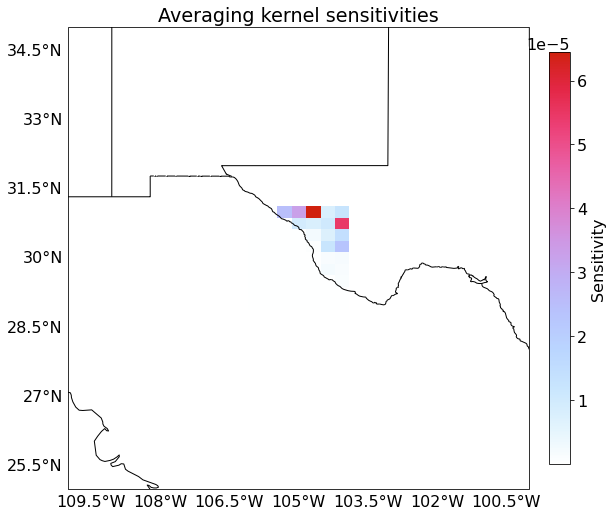

In [17]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, avkern_ROI, cmap=cc.cm.CET_L19, plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Averaging kernel sensitivities', cbar_label='Sensitivity', 
           only_ROI=True)

In [18]:
DOFS = np.nansum(avkern_ROI.values)
print('DOFS =', DOFS)

DOFS = 0.0002965544960993327


# Compare TROPOMI and GEOS-Chem columns

In [18]:
# Shrink the lat/lon bounds
#lat_bounds = [28, 35.5]
#lon_bounds = [-107, -98.5]

In [19]:
# Get observed and GEOS-Chem-simulated TROPOMI columns
files = np.sort(os.listdir(satdat_dir))
lat = np.array([])
lon = np.array([])
tropomi = np.array([])
geos_prior = np.array([])
geos_posterior = np.array([])

for f in files:
    # Get paths
    pth = os.path.join(satdat_dir,f)
    pth_posterior = os.path.join(posterior_dir,f)
    # Load TROPOMI/GEOS-Chem and Jacobian matrix data from the .pkl file
    obj = load_obj(pth)
    obj_posterior = load_obj(pth_posterior)
    # If there aren't any TROPOMI observations on this day, skip
    if obj['obs_GC'].shape[0] == 0:
        continue
    # Otherwise, grab the TROPOMI/GEOS-Chem data
    obs_GC = obj['obs_GC']
    obs_GC_posterior = obj_posterior['obs_GC']
    # Only consider data within latitude and longitude bounds
    ind = np.where((obs_GC[:,2]>=lon_bounds[0]) & (obs_GC[:,2]<=lon_bounds[1]) & 
                   (obs_GC[:,3]>=lat_bounds[0]) & (obs_GC[:,3]<=lat_bounds[1]))
    if (len(ind[0]) == 0):          # Skip if no data in bounds
        continue
    obs_GC = obs_GC[ind[0],:]       # TROPOMI and GEOS-Chem data within bounds
    obs_GC_posterior = obs_GC_posterior[ind[0],:]
    # Record lat, lon, tropomi ch4, and geos ch4
    lat = np.concatenate((lat, obs_GC[:,3]))
    lon = np.concatenate((lon, obs_GC[:,2]))
    tropomi = np.concatenate((tropomi, obs_GC[:,0]))
    geos_prior = np.concatenate((geos_prior, obs_GC[:,1]))
    geos_posterior = np.concatenate((geos_posterior, obs_GC_posterior[:,1]))
    
df = pd.DataFrame()
df['lat'] = lat
df['lon'] = lon
df['tropomi'] = tropomi
df['geos_prior'] = geos_prior
df['geos_posterior'] = geos_posterior
df['diff_tropomi_prior'] = geos_prior - tropomi
df['diff_tropomi_posterior'] = geos_posterior - tropomi
n_obs = len(tropomi)

print('Found',n_obs,'TROPOMI observations')
df.head()

Found 14175 TROPOMI observations


,lat,lon,tropomi,geos_prior,diff_tropomi_prior
0,25.015081,-101.137886,1840.096924,1829.971313,-10.125610
1,25.210379,-100.650566,1852.977661,1825.622437,-27.355225
2,25.047247,-101.745094,1824.424927,1831.164429,6.739502
3,25.264778,-101.217979,1845.239014,1826.469971,-18.769043
4,25.346073,-101.536949,1854.547241,1828.033936,-26.513306


Note: this observation count is for the smaller lat/lon domain defined by the new lat/lon bounds above. For the full inversion domain, use the original lat/lon bounds from the top of the Inversion Results section.

In [20]:
# Print some error statistics
print('Bias in prior     :'  , np.round(df['diff_tropomi_prior'].mean(),2),'ppb')
print('Bias in posterior :'  , np.round(df['diff_tropomi_posterior'].mean(),2),'ppb')
print('RMSE prior        :'  , np.round(np.sqrt(np.mean(df['diff_tropomi_prior']**2)),2),'ppb')
print('RMSE posterior    :'  , np.round(np.sqrt(np.mean(df['diff_tropomi_posterior']**2)),2),'ppb')

Bias in prior     : -0.67 ppb
Bias in posterior : -0.11 ppb
RMSE prior        : 12.07 ppb
RMSE posterior    : 11.42 ppb


### Compare at 0.1 x 0.1 resolution

In [21]:
# Simple averaging scheme to grid the XCH4 data at 0.1 x 0.1 resolution
df_copy = df.copy() # save for later
df['lat'] = np.round(df['lat'],1)
df['lon'] = np.round(df['lon'],1)
df = df.groupby(['lat','lon']).mean()
ds = df.to_xarray()
ds

<xarray.Dataset>
Dimensions:                 (lat: 76, lon: 86)
Coordinates:
  * lat                     (lat) float64 28.0 28.1 28.2 28.3 ... 35.3 35.4 35.5
  * lon                     (lon) float64 -107.0 -106.9 -106.8 ... -98.6 -98.5
Data variables:
    tropomi                 (lat, lon) float64 1.812e+03 nan ... nan nan
    geos_prior              (lat, lon) float64 1.827e+03 nan ... nan nan
    geos_posterior          (lat, lon) float64 1.826e+03 nan ... nan nan
    diff_tropomi_prior      (lat, lon) float64 14.95 nan 12.81 ... nan nan nan
    diff_tropomi_posterior  (lat, lon) float64 14.4 nan 12.03 ... nan nan nan

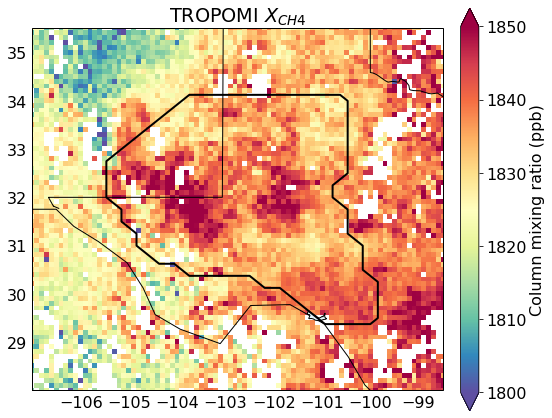

In [22]:
# Mean TROPOMI XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds['tropomi'], cmap='Spectral_r', plot_type='imshow',
           vmin=1800, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='TROPOMI $X_{CH4}$', cbar_label='Column mixing ratio (ppb)', 
           mask=mask, only_ROI=False)

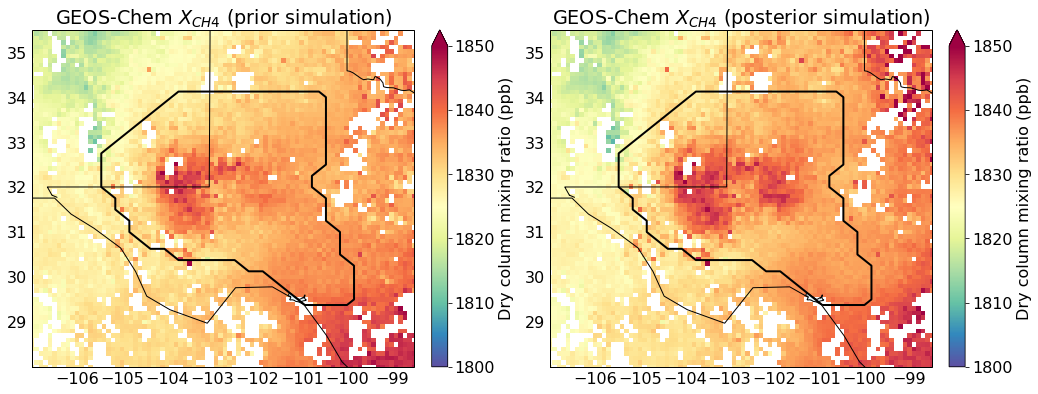

In [23]:
# Mean prior and posterior GEOS-Chem XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(17,6.2))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds['geos_prior'], cmap='Spectral_r', plot_type='imshow',
           vmin=1800, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='GEOS-Chem $X_{CH4}$ (prior simulation)', cbar_label='Dry column mixing ratio (ppb)', 
           mask=mask, only_ROI=False)

plot_field(ax2, ds['geos_posterior'], cmap='Spectral_r', plot_type='imshow',
           vmin=1800, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='GEOS-Chem $X_{CH4}$ (posterior simulation)', cbar_label='Dry column mixing ratio (ppb)', 
           mask=mask, only_ROI=False)

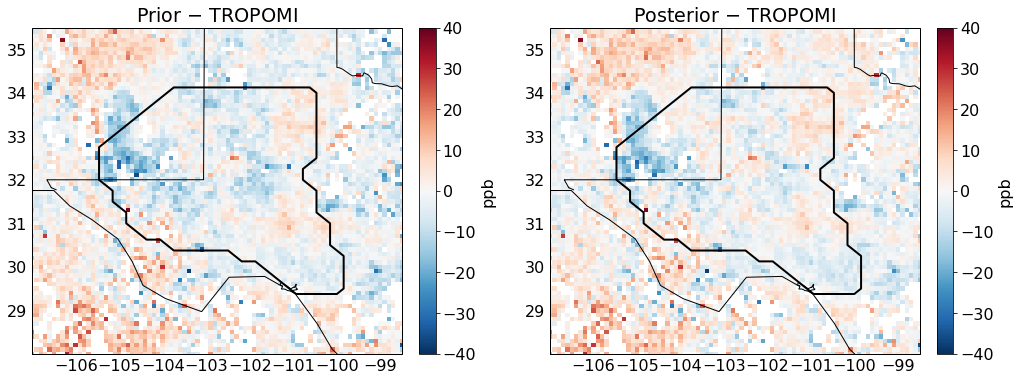

In [24]:
# Plot differences between GEOS-Chem and TROPOMI XCH4
fig = plt.figure(figsize=(17,6))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds['diff_tropomi_prior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-40, vmax=40, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Prior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

plot_field(ax2, ds['diff_tropomi_posterior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-40, vmax=40, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

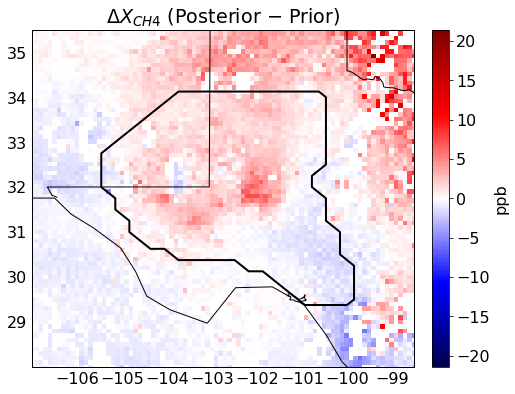

In [25]:
# Plot differences between posterior and prior simulated XCH4
fig = plt.figure(figsize=(8,6.2))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds['geos_posterior']-ds['geos_prior'], 
           cmap='seismic', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='$\Delta X_{CH4}$ (Posterior $-$ Prior)', cbar_label='ppb', 
           mask=mask, only_ROI=False)

### Compare at 0.25 x 0.3125 resolution

In [26]:
# Global 0.25 x 0.3125 grid
reference_lat_grid = np.arange(-90 , 90+0.25   , 0.25)
reference_lon_grid = np.arange(-180, 180+0.3125, 0.3125)

# Find closest reference coordinates to selected lat/lon bounds
lat_min = reference_lat_grid[np.abs(reference_lat_grid - lat_bounds[0]).argmin()]
lon_min = reference_lon_grid[np.abs(reference_lon_grid - lon_bounds[0]).argmin()]
lat_max = reference_lat_grid[np.abs(reference_lat_grid - lat_bounds[1]).argmin()]
lon_max = reference_lon_grid[np.abs(reference_lon_grid - lon_bounds[1]).argmin()]

# Create an xESMF regridder object to resample the data on the grid HEMCO expects
new_lat_grid = np.arange(lat_min, lat_max+0.25, 0.25)
new_lon_grid = np.arange(lon_min, lon_max+0.3125, 0.3125)
ds_out = xr.Dataset({'lat': (['lat'], new_lat_grid),
                     'lon': (['lon'], new_lon_grid),
                    }
                   )

regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_76x86_31x28.nc 
Reuse pre-computed weights? False 
Input grid shape:           (76, 86) 
Output grid shape:          (31, 28) 
Periodic in longitude?      False

In [27]:
# Regrid the data
ds_regrid = regridder(ds)
ds_regrid

<xarray.Dataset>
Dimensions:                 (lat: 31, lon: 28)
Coordinates:
  * lon                     (lon) float64 -106.9 -106.6 -106.2 ... -98.75 -98.44
  * lat                     (lat) float64 28.0 28.25 28.5 ... 35.0 35.25 35.5
Data variables:
    tropomi                 (lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0
    geos_prior              (lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0
    geos_posterior          (lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0
    diff_tropomi_prior      (lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0
    diff_tropomi_posterior  (lat, lon) float64 0.0 0.0 0.0 0.0 ... nan nan 0.0
Attributes:
    regrid_method:  bilinear

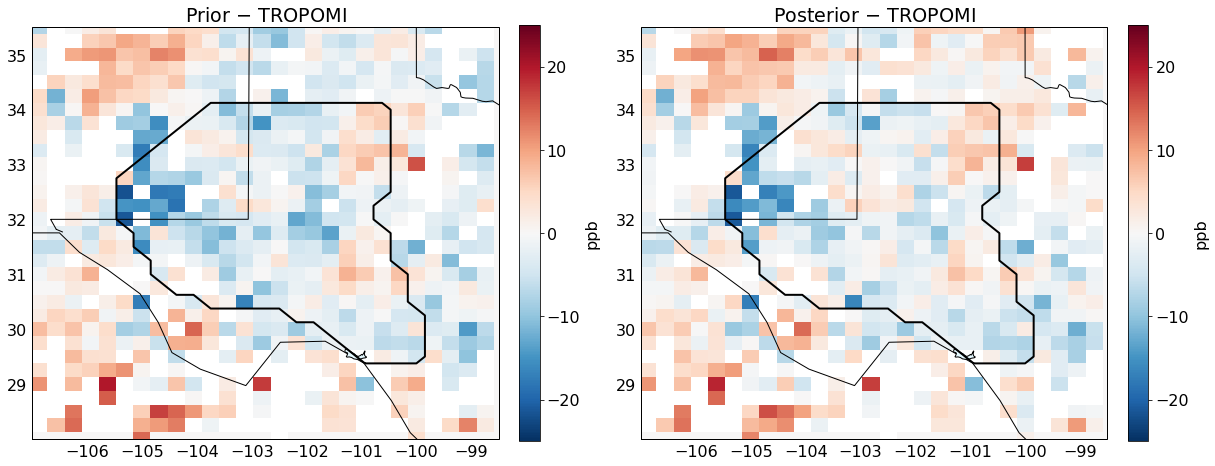

In [28]:
# Re-plot differences between GEOS-Chem and TROPOMI XCH4
fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds_regrid['diff_tropomi_prior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-25, vmax=25, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Prior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

plot_field(ax2, ds_regrid['diff_tropomi_posterior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-25, vmax=25, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ TROPOMI', cbar_label='ppb', 
           mask=mask, only_ROI=False)

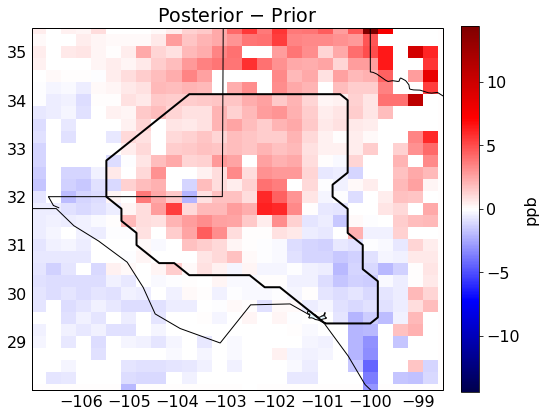

In [29]:
# Re-plot differences between posterior and prior simulated XCH4
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds_regrid['geos_posterior']-ds_regrid['geos_prior'], 
           cmap='seismic', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ Prior', cbar_label='ppb', 
           mask=mask, only_ROI=False)

# Count observations within the region of interest

In [30]:
# We saved a copy of the dataframe from earlier
df_copy.head()

,lat,lon,tropomi,geos_prior,geos_posterior,diff_tropomi_prior,diff_tropomi_posterior
0,28.012594,-100.669044,1858.840088,1835.922363,1836.245239,-22.917725,-22.594849
1,28.034594,-100.797401,1860.817383,1834.530884,1834.401978,-26.286499,-26.415405
2,28.013126,-101.038971,1845.638550,1835.646851,1835.178711,-9.991699,-10.459839
3,28.055569,-100.927597,1847.030762,1835.055786,1834.643311,-11.974976,-12.387451
4,28.097046,-100.817909,1862.050049,1834.766357,1834.500610,-27.283691,-27.549438


In [31]:
# Add a column to count observations
df_copy['n'] = 1

# Round lat/lon to 0.1 deg, group by lat/lon, and drop unneeded columns
df_copy['lat'] = np.round(df_copy['lat'],1)
df_copy['lon'] = np.round(df_copy['lon'],1)
df_copy = df_copy.groupby(['lat','lon']).sum().drop(['tropomi','geos_prior','geos_posterior',
                                                     'diff_tropomi_prior','diff_tropomi_posterior'], axis=1)
df_copy.head()

n
lat  lon      
28.0 -107.0  1
     -106.8  2
     -106.7  2
     -106.5  4
     -106.2  3

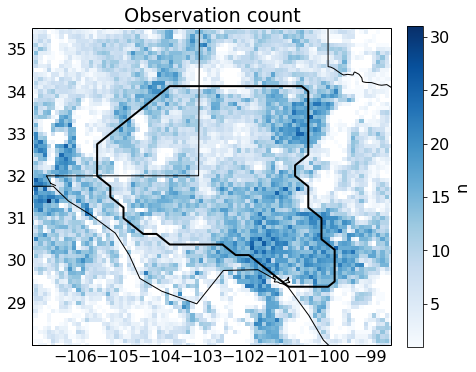

In [32]:
# Show the observation counts on a map
ds_count = df_copy.to_xarray()

fig = plt.figure(figsize=(7,7))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds_count['n'], 
           cmap='Blues', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Observation count', cbar_label='n', 
           mask=mask, only_ROI=False)

In [33]:
# Regrid the region mask to 0.1 deg resolution to match the observation counts
ds_out_2 = xr.Dataset({'lat': (['lat'], ds_count['lat'].values),
                       'lon': (['lon'], ds_count['lon'].values),
                      }
                     )

regridder_2 = xe.Regridder(mask, ds_out_2, 'nearest_s2d')
regridder_2

/Users/danielvaron/anaconda/envs/tropomi_nigeria_py3.6/lib/python3.6/site-packages/xarray/core/dataarray.py:670: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_61x52_76x86.nc 
Reuse pre-computed weights? False 
Input grid shape:           (61, 52) 
Output grid shape:          (76, 86) 
Periodic in longitude?      False

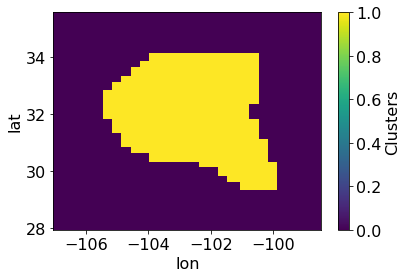

In [34]:
# Regrid the mask
mask_regridded = regridder_2(mask)
mask_regridded.plot();

In [35]:
# Count up the observations inside the mask
obs_in_mask = ds_count['n'].values * mask_regridded.values
print('Found',int(np.nansum(obs_in_mask)),'observations within the region of interest')

Found 20220 observations within the region of interest


----